# Cook Book

This notebook contains some more advanced examples addressing common usage patterns.  Look at the Tutorial first to get a better sense of the big picture of the tools.

In [1]:
# Set the number of OpenMP threads to use
import os
os.environ["OMP_NUM_THREADS"] = "4"

In [2]:
import time
import numpy as np
import h5py
from flacarray import FlacArray, demo
import flacarray.hdf5

## Random Access to Large Arrays

Consider a common case where we have a 2D array that represents essentially a "list" of timestreams of data.  We might have thousands of timestreams, each with millions of samples.  Now we want to decompress and access a subset of those streams and / or samples.  To reduce memory in this notebook we are using a slightly smaller array.

In [3]:
# Create a 2D array of streams
arr, _ = demo.create_fake_data((1000, 100000), dtype=np.float32)
# How large is this in memory?
print(f"Input array is {arr.nbytes} bytes")

Input array is 400000000 bytes


In [4]:
# Compress this with threads
start = time.perf_counter()

flcarr = FlacArray.from_array(arr, quanta=1.0e-7, use_threads=True)

stop = time.perf_counter()
print(f"Elapsed = {stop-start:0.3} seconds")

Elapsed = 1.23 seconds


In [5]:
# Compress this without threads
start = time.perf_counter()

flcarr = FlacArray.from_array(arr, quanta=1.0e-7, use_threads=False)

stop = time.perf_counter()
print(f"Elapsed = {stop-start:0.3} seconds")

Elapsed = 2.6 seconds


In [6]:
# Decompress the whole thing
start = time.perf_counter()

restored = flcarr.to_array()

stop = time.perf_counter()
print(f"Elapsed = {stop-start:0.3} seconds")

Elapsed = 0.447 seconds


In [7]:
# Decompress the whole thing with threads
del restored
start = time.perf_counter()

restored = flcarr.to_array(use_threads=True)

stop = time.perf_counter()
print(f"Elapsed = {stop-start:0.3} seconds")

Elapsed = 0.439 seconds


### Subset of Samples for All Streams

If our 2D array of streams contains co-sampled data, we might mant to examine a slice in time of all streams.  Imagine we wanted to get data near the end of the array for all streams:

In [8]:
n_end = 10000
start = time.perf_counter()

end_arr = flcarr.to_array(stream_slice=slice(-n_end, None, 1))

stop = time.perf_counter()
print(f"Elapsed = {stop-start:0.3} seconds")

Elapsed = 0.43 seconds


### Subset of Samples for a Few Streams

Imagine we want the last 1000 samples of **one** stream in the middle.  We can use a "keep" mask combined with a sample slice:

In [9]:
n_end = 10000
keep = np.zeros(arr.shape[:-1], dtype=bool)
keep[500] = True
start = time.perf_counter()

sub_arr = flcarr.to_array(keep=keep, stream_slice=slice(-n_end, None, 1))

stop = time.perf_counter()
print(f"Elapsed = {stop-start:0.3} seconds")
print(sub_arr)

Elapsed = 0.00201 seconds
[[ 1.3499217   1.1607051  -1.0080613  ...  0.2447555   1.0821551
   0.03497732]]


So, we can see that decompressing a small number of random samples from a multi-GB dataset in memory is very fast.

## Quantization Effects

As mentioned previously, 32 and 64 bit integer data is compressed in a lossless fashion with FLAC, using either one or two audio channels.  When compressing 32 or 64 bit floating point data, a choice must be made about the "amount" of floating point value assigned to each integer.  This `quanta` parameter is a tradeoff between fidelity of the input data and compression factor.  One "safe" choice is to pick a quantization value that is near the machine epsilon for float32 or float64.  Although this will ensure nearly lossless compression, the compression ratio will be very poor.

To achieve better compression of floating point data, you should consider the dynamic range and actual precision of this data.  As an example, consider some fake 32 bit floating point data: 

In [10]:
# Create a single timestream
arr, _ = demo.create_fake_data((10000,), dtype=np.float32)
# How large is this in memory?
print(f"Input array is {arr.nbytes} bytes")

Input array is 40000 bytes


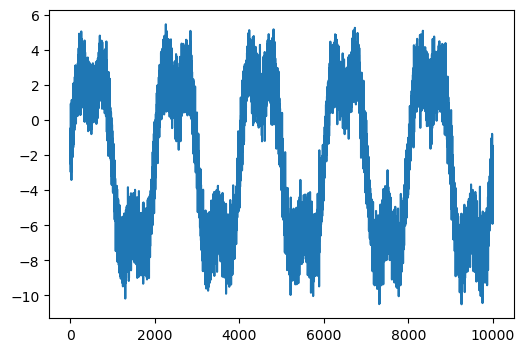

In [11]:
# Plot this
demo.plot_data(arr)

Now compress / decompress this data with a very conservative `quanta` value:

In [12]:
# Create a compressed array
flcarr = FlacArray.from_array(arr, quanta=1.0e-8)

How big is this compressed array?

In [13]:
print(f"FlacArray is {flcarr.nbytes} bytes")

FlacArray is 36161 bytes


So we see that our compression factor is only about 0.9 (not good)

In [14]:
# Restore back to an array
restored = flcarr.to_array()

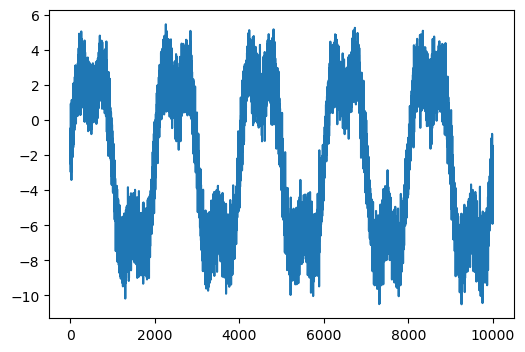

In [15]:
demo.plot_data(restored)

In [16]:
# Difference
residual = restored - arr

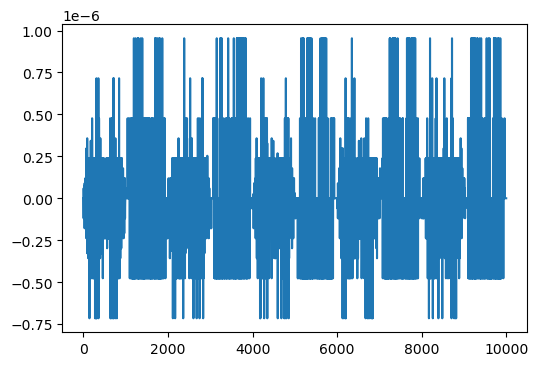

In [17]:
demo.plot_data(residual)

The residual difference after the roundtrip compression / decompression is close to the machine precision for float32.

### Decreased Precision

Now imagine that we know the underlying precision of our data above is not really at the level of machine precision for float32.  Instead, we know that our data came from measurements with a precision of 1.0e-4 in the units of this dataset.  We can use that information when compressing:

In [18]:
# Create a compressed array
flcarr = FlacArray.from_array(arr, quanta=1.0e-4)

How big is this lower-precision compressed array?

In [19]:
print(f"FlacArray is {flcarr.nbytes} bytes")

FlacArray is 19664 bytes


So we have used information about our data to avoid storing unnecessary precision and have improved our compression ratio.

In [20]:
# Restore back to an array
restored = flcarr.to_array()

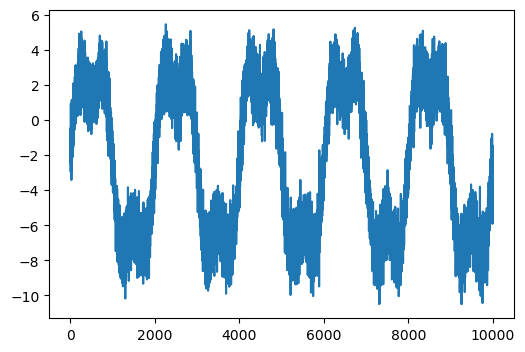

In [21]:
demo.plot_data(restored)

In [22]:
# Difference
residual = restored - arr

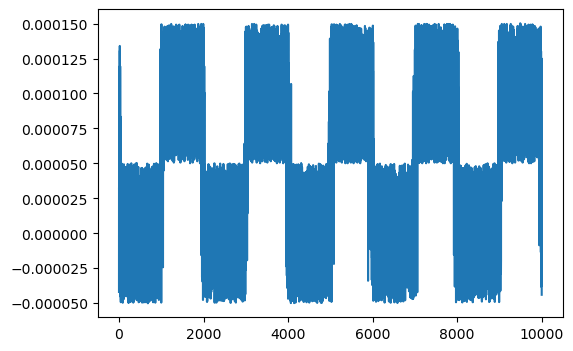

In [23]:
demo.plot_data(residual)

As expected, the residual is now comparable to the size of the quanta that we used.

## Parallel I/O

To-Do:  Discuss
- Interaction of threads, OpenMP versus libFLAC pthreads
- Use of MPI HDF5 with h5py